<a href="https://colab.research.google.com/github/soumnemishra/Breast_cancer_detection/blob/main/breast_cancer_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GOOGLE DRIVE MOUNT


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
import pathlib
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
# Import BatchNormalization directly from tensorflow.keras.layers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
# Rescaling is now likely directly under tf.keras.layers
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding



In [ ]:
# Dataset path
dataset_path = "/content/drive/MyDrive/breast_cancer_project/breast_Cancer_datasets_/Dataset_BUSI_with_GT"

In [19]:
import os
import shutil
import re

# Define the root directory where your dataset is located
dataset_path = '/content/drive/MyDrive/breast_cancer_project/breast_Cancer_datasets_/Dataset_BUSI_with_GT'

# Directories for the normal ultrasound images and the masks
normal_dir = os.path.join(dataset_path, 'normal')
benign_dir = os.path.join(dataset_path, 'benign')
malignant_dir = os.path.join(dataset_path, 'malignant')

# Directories for the mask images
normal_mask_dir = os.path.join(dataset_path, 'normal_masks')
benign_mask_dir = os.path.join(dataset_path, 'benign_masks')
malignant_mask_dir = os.path.join(dataset_path, 'malignant_masks')

# Create directories for the masks (if they don't exist)
os.makedirs(normal_mask_dir, exist_ok=True)
os.makedirs(benign_mask_dir, exist_ok=True)
os.makedirs(malignant_mask_dir, exist_ok=True)

# Function to move mask images into the correct mask directory
def move_mask_images(image_dir, mask_dir, class_name):
    # List all the files in the image directory
    for filename in os.listdir(image_dir):
        # If the filename contains '_mask' (case insensitive), it is a mask image
        if '_mask' in filename.lower():
            # Regex to identify the base image name, removing any mask-related suffix
            base_name = re.sub(r'(_mask.*)', '', filename)  # Remove '_mask' and everything after it
            # Check if a corresponding original image exists
            base_image_path = os.path.join(image_dir, base_name + '.png')

            if os.path.exists(base_image_path):
                # Construct full file path for the image and the target mask directory
                mask_image_path = os.path.join(image_dir, filename)
                target_mask_dir = os.path.join(mask_dir, filename)

                # Move the mask image to its respective directory
                shutil.move(mask_image_path, target_mask_dir)
                print(f'Moved {filename} from {image_dir} to {mask_dir}')
            else:
                print(f"Warning: Base image {base_name} not found for mask {filename}")

# Move mask images from each class to the mask directories
move_mask_images(benign_dir, benign_mask_dir, 'benign')
move_mask_images(malignant_dir, malignant_mask_dir, 'malignant')
move_mask_images(normal_dir, normal_mask_dir, 'normal')

# Now remove any remaining mask files from the original directories (optional check)
def remove_remaining_masks(image_dir):
    for filename in os.listdir(image_dir):
        if '_mask' in filename.lower():  # Check if file name contains '_mask'
            os.remove(os.path.join(image_dir, filename))
            print(f"Removed {filename} from {image_dir}")

# Remove any remaining mask images from the original folders
remove_remaining_masks(benign_dir)
remove_remaining_masks(malignant_dir)
remove_remaining_masks(normal_dir)

print("Mask images have been successfully moved and removed from original folders!")


Mask images have been successfully moved and removed from original folders!


In [13]:
# Check the number of images in each category after mask separation
dataset_path = "/content/drive/MyDrive/breast_cancer_project/breast_Cancer_datasets_/Dataset_BUSI_with_GT"
categories = ["benign", "malignant", "normal"]

# Check number of images
for category in categories:
    category_path = os.path.join(dataset_path, category)
    # Count only image files (ignoring mask files)
    image_files = [f for f in os.listdir(category_path) if not f.endswith('_mask.png')]
    print(f"{category}: {len(image_files)} images (after mask separation)")


benign: 442 images (after mask separation)
malignant: 210 images (after mask separation)
normal: 133 images (after mask separation)


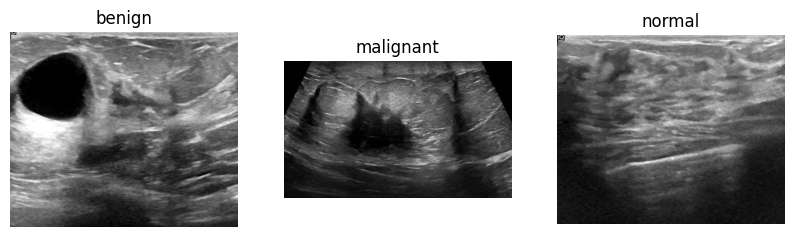

In [14]:
# Display sample images from the directories (after mask separation)
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
for i, category in enumerate(categories):
    category_path = os.path.join(dataset_path, category)
    image_files = [f for f in os.listdir(category_path) if not f.endswith('_mask.png')]

    img_path = os.path.join(category_path, image_files[0])  # Take first image from each category
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    axes[i].imshow(img, cmap="gray")
    axes[i].set_title(category)
    axes[i].axis("off")
plt.show()

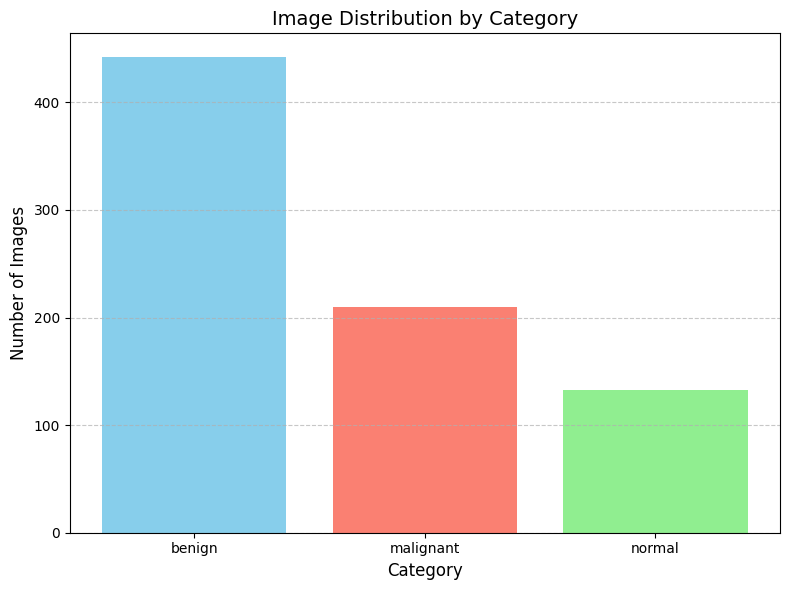

In [20]:

# Categories
categories = ["benign", "malignant", "normal"]

# Count the number of images per category (excluding mask images)
image_counts = {}

for category in categories:
    category_path = os.path.join(dataset_path, category)
    image_list = [img for img in os.listdir(category_path) if "_mask" not in img]
    image_counts[category] = len(image_list)

# Plotting the bar chart
plt.figure(figsize=(8, 6))
plt.bar(image_counts.keys(), image_counts.values(), color=['skyblue', 'salmon', 'lightgreen'])
plt.title("Image Distribution by Category", fontsize=14)
plt.xlabel("Category", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Mask Images

In [15]:
# Check the number of mask images in each category
mask_categories = ["benign_masks", "malignant_masks", "normal_masks"]
for category in mask_categories:
    mask_category_path = os.path.join(dataset_path, category)
    mask_files = os.listdir(mask_category_path)
    print(f"{category}: {len(mask_files)} masks")


benign_masks: 459 masks
malignant_masks: 211 masks
normal_masks: 133 masks


In [18]:
def preprocess_images(image_path, image_size=(224, 224)):
    img = cv2.imread(image_path)
    img = cv2.resize(img, image_size)
    img = img / 255.0  # Normalizing the image (0-1 range)
    return img
